In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('983.csv')
df.shape

(983, 3)

In [2]:
df.tail()

,label,id,sequence
978,Inner,Q9P7D8,MCISSSSLLCGINSLKYASNRVGILIPPFQTASSLNIFRPYVIFSR...
979,Outer,Q06089,MCLVKTTAHLLFYSFVFGGTTFYSYVASPIAFKVLEKDQFSALQNK...
980,Inner,Q09461,MPSPCESGKTTNCSGAPSSSCAKSVECCKKQLSVGVLQQVSASSSG...
981,Inner,B3LPE4,MIPRTRTLLQSKIPITRYFARCWAPRVRYNVCRTLPAAALHTNIIA...
982,Outer,Q9VKD7,MLITQIIMKQIRDYPIVSTISIAVSTVLASEVIWKLVQCSRSKREK...


at least 145 instances per class
983 instances before
983 instances after


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


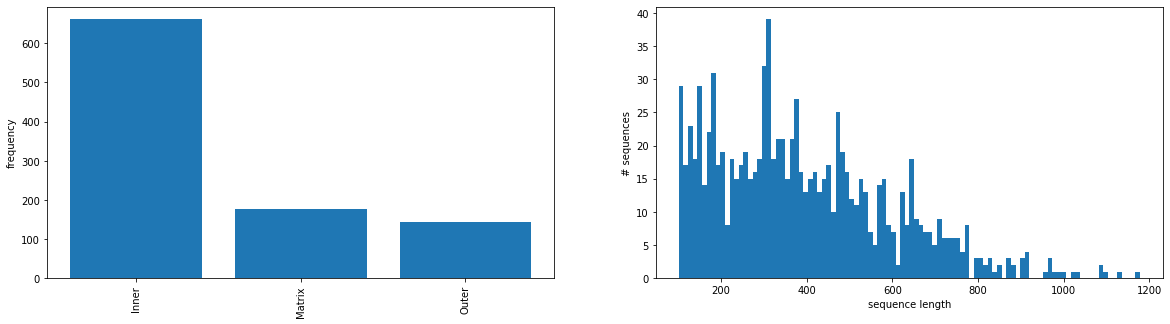

In [4]:
import matplotlib.pyplot as plt
from collections import Counter

# count numbers of instances per class
cnt = Counter(df.label)
# select only 10 most common classes!
top_classes = 3
# sort classes
sorted_classes = cnt.most_common()[:top_classes]
classes = [c[0] for c in sorted_classes]
counts = [c[1] for c in sorted_classes]
print("at least " + str(counts[-1]) + " instances per class")

# apply to dataframe
print(str(df.shape[0]) + " instances before")
df = df[[c in classes for c in df.label]]
print(str(df.shape[0]) + " instances after")

seqs = df.sequence.values
lengths = [len(s) for s in seqs]

# visualize
fig, axarr = plt.subplots(1,2, figsize=(20,5))
axarr[0].bar(range(len(classes)), counts)
plt.sca(axarr[0])
plt.xticks(range(len(classes)), classes, rotation='vertical')
axarr[0].set_ylabel('frequency')

axarr[1].hist(lengths, bins=100, normed=False)
axarr[1].set_xlabel('sequence length')
axarr[1].set_ylabel('# sequences')
plt.show()

In [5]:
from sklearn.preprocessing import LabelBinarizer

# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(df.label)

In [7]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# maximum length of sequence, everything afterwards is discarded!
max_length = 800

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(seqs)
X = sequence.pad_sequences(X, maxlen=max_length)

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

embedding_dim = 20

# create the model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(top_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 20)           420       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 800, 64)           3904      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 400, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 32)           6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 16)           1552      
________________________________________________

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

Train on 786 samples, validate on 197 samples
Epoch 1/10
786/786 [==============================] - 2s 3ms/step - loss: 0.8759 - accuracy: 0.6616 - val_loss: 0.8253 - val_accuracy: 0.6954
Epoch 2/10
786/786 [==============================] - 2s 2ms/step - loss: 0.8461 - accuracy: 0.6667 - val_loss: 0.8038 - val_accuracy: 0.6954
Epoch 3/10
786/786 [==============================] - 2s 2ms/step - loss: 0.8349 - accuracy: 0.6667 - val_loss: 0.7704 - val_accuracy: 0.6954
Epoch 4/10
786/786 [==============================] - 2s 2ms/step - loss: 0.8193 - accuracy: 0.6667 - val_loss: 0.7703 - val_accuracy: 0.6954
Epoch 5/10
786/786 [==============================] - 2s 2ms/step - loss: 0.7754 - accuracy: 0.6667 - val_loss: 0.7283 - val_accuracy: 0.6954
Epoch 6/10
786/786 [==============================] - 2s 2ms/step - loss: 0.7214 - accuracy: 0.6628 - val_loss: 0.7750 - val_accuracy: 0.6904
Epoch 7/10
786/786 [==============================] - 2s 2ms/step - loss: 0.6868 - accuracy: 0.6730 - 

train-acc = 0.8320610687022901
test-acc = 0.6802030456852792


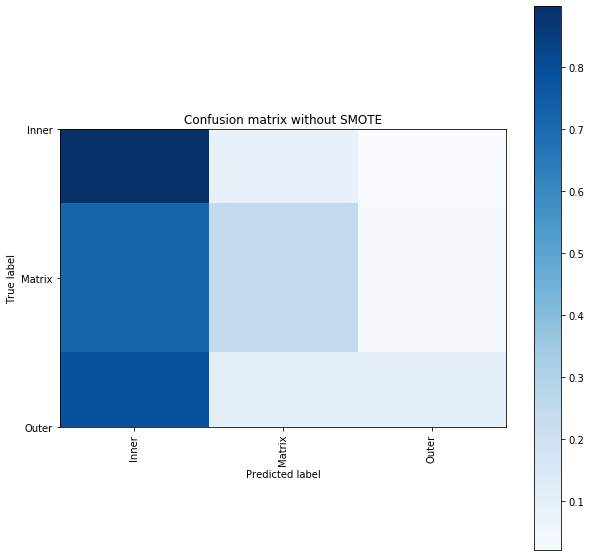

              precision    recall  f1-score   support

       Inner       0.73      0.90      0.81       137
      Matrix       0.36      0.25      0.30        32
       Outer       0.43      0.11      0.17        28

    accuracy                           0.68       197
   macro avg       0.51      0.42      0.42       197
weighted avg       0.63      0.68      0.63       197



In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import itertools

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
print("train-acc = " + str(accuracy_score(np.argmax(y_train, axis=1), np.argmax(train_pred, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))))

# Compute confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1))

# Plot normalized confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.set_printoptions(precision=2)
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix without SMOTE')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_, rotation=90)
plt.yticks(tick_marks, lb.classes_)
#for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(np.argmax(y_test, axis=1), np.argmax(test_pred, axis=1), target_names=lb.classes_))